In [1]:
# 1. Import libraries
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Load dataset
news_data = "news_articles.csv"

# Define the path to the dataset
dataset_path = os.path.join('data', 'news_articles.csv')

data = pd.read_csv(dataset_path)
print(f"Original data shape: {data.shape}")

# Drop missing values
data.dropna(inplace=True)

# Drop duplicates
data.drop_duplicates(inplace=True)

print(f"Data shape after cleaning: {data.shape}")

Original data shape: (2096, 12)
Data shape after cleaning: (2035, 12)


Exploratory data analysis (EDA)

In [5]:
# Understand the distribution of features and their relationship with the target variable
# Exploratory Data Analysis
print("\n==== Basic Dataset Information ====")
print(data.info())

print("\n==== Statistical Summary ====")
print(data.describe(include='all'))

# Check for class distribution (Real vs Fake news)
print("\n==== Target Variable Distribution ====")
label_counts = data['label'].value_counts()
label_percentages = data['label'].value_counts(normalize=True) * 100
print("Label Count:")
print(label_counts)
print("\nLabel Percentage:")
print(f"Real: {label_percentages['Real']:.2f}%")
print(f"Fake: {label_percentages['Fake']:.2f}%")


==== Basic Dataset Information ====
<class 'pandas.core.frame.DataFrame'>
Index: 2035 entries, 0 to 2045
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   2035 non-null   object 
 1   published                2035 non-null   object 
 2   title                    2035 non-null   object 
 3   text                     2035 non-null   object 
 4   language                 2035 non-null   object 
 5   site_url                 2035 non-null   object 
 6   main_img_url             2035 non-null   object 
 7   type                     2035 non-null   object 
 8   label                    2035 non-null   object 
 9   title_without_stopwords  2035 non-null   object 
 10  text_without_stopwords   2035 non-null   object 
 11  hasImage                 2035 non-null   float64
dtypes: float64(1), object(11)
memory usage: 206.7+ KB
None

==== Statistical Summary ====
           aut

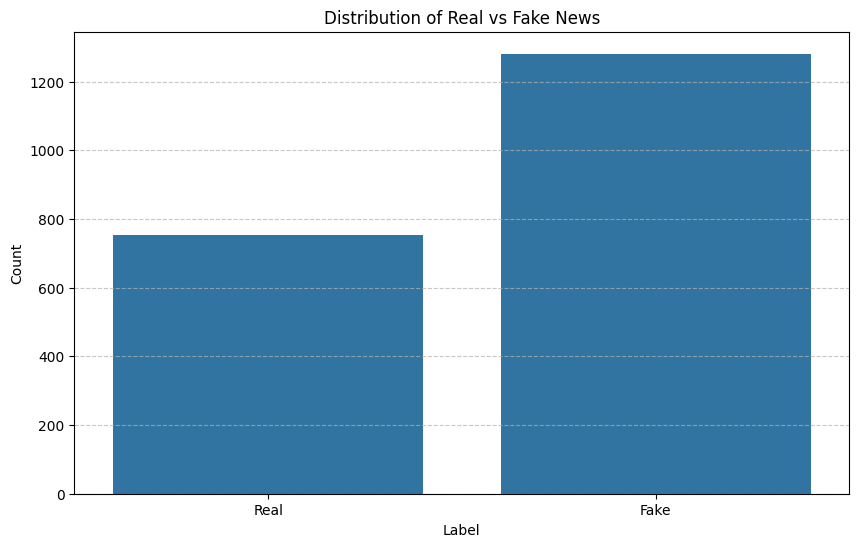

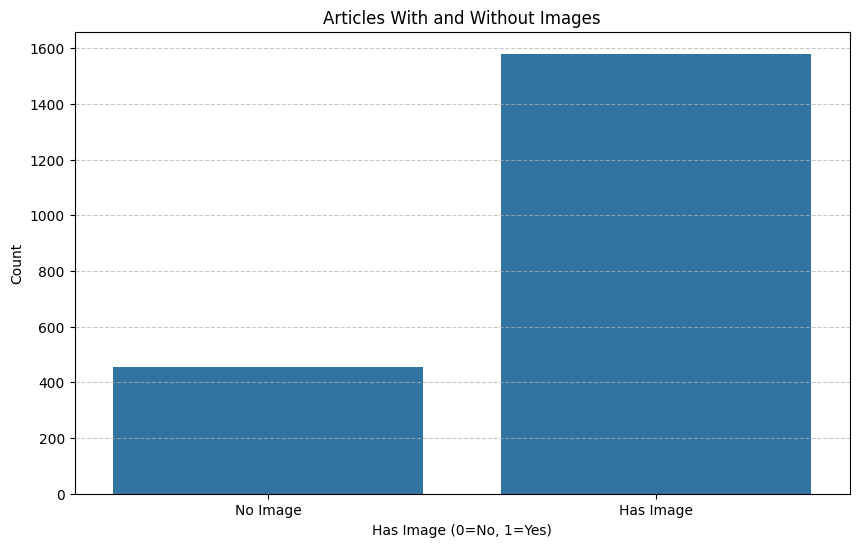

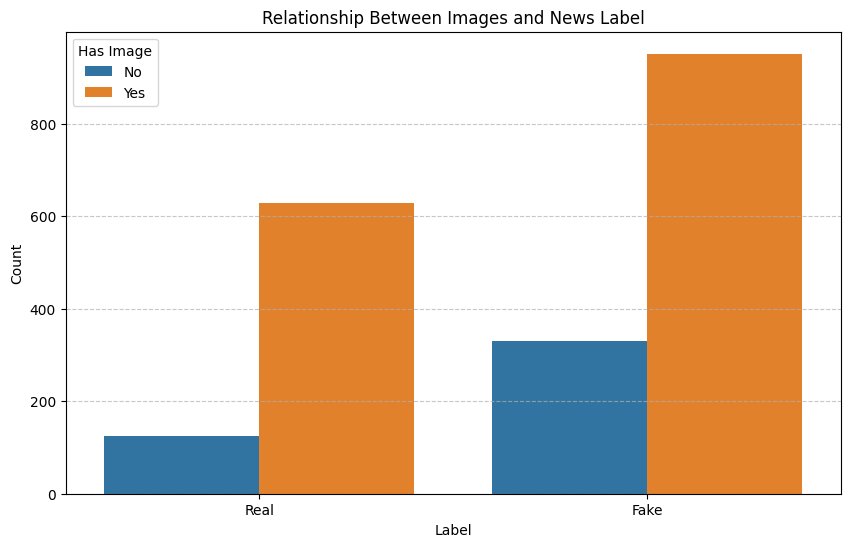

In [6]:
# Visualize the distribution of Real vs Fake news
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=data)
plt.title('Distribution of Real vs Fake News')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualize the presence of images in articles
plt.figure(figsize=(10, 6))
sns.countplot(x='hasImage', data=data)
plt.title('Articles With and Without Images')
plt.xlabel('Has Image (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Image', 'Has Image'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Check if there's a relationship between images and fake news
plt.figure(figsize=(10, 6))
sns.countplot(x='label', hue='hasImage', data=data)
plt.title('Relationship Between Images and News Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.legend(title='Has Image', labels=['No', 'Yes'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

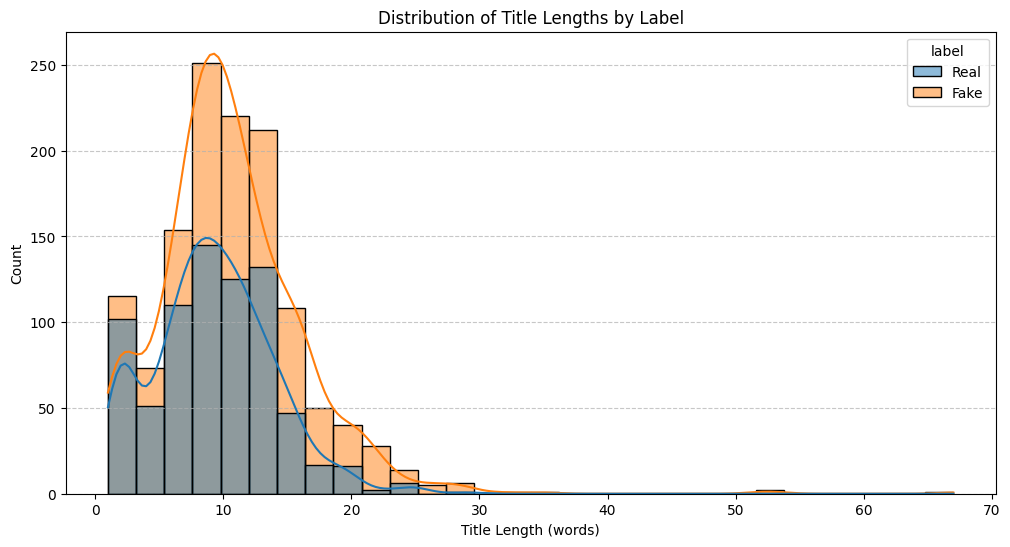

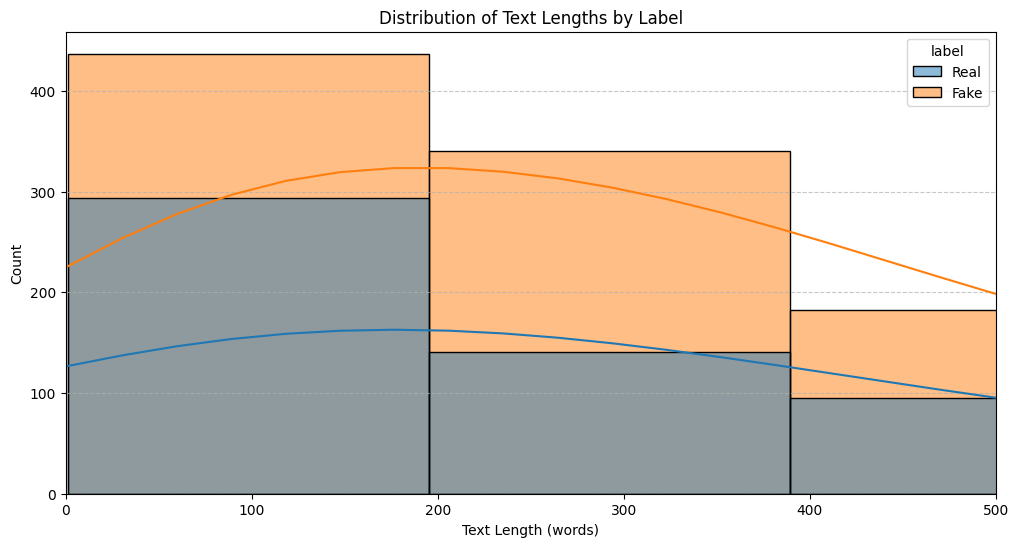

In [7]:
# Analyze text length distributions
data['title_length'] = data['title'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
data['text_length'] = data['text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='title_length', hue='label', bins=30, kde=True)
plt.title('Distribution of Title Lengths by Label')
plt.xlabel('Title Length (words)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='text_length', hue='label', bins=30, kde=True)
plt.title('Distribution of Text Lengths by Label')
plt.xlabel('Text Length (words)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0, 500)  # Limiting x-axis for better visualization
plt.show()

<Figure size 1400x800 with 0 Axes>

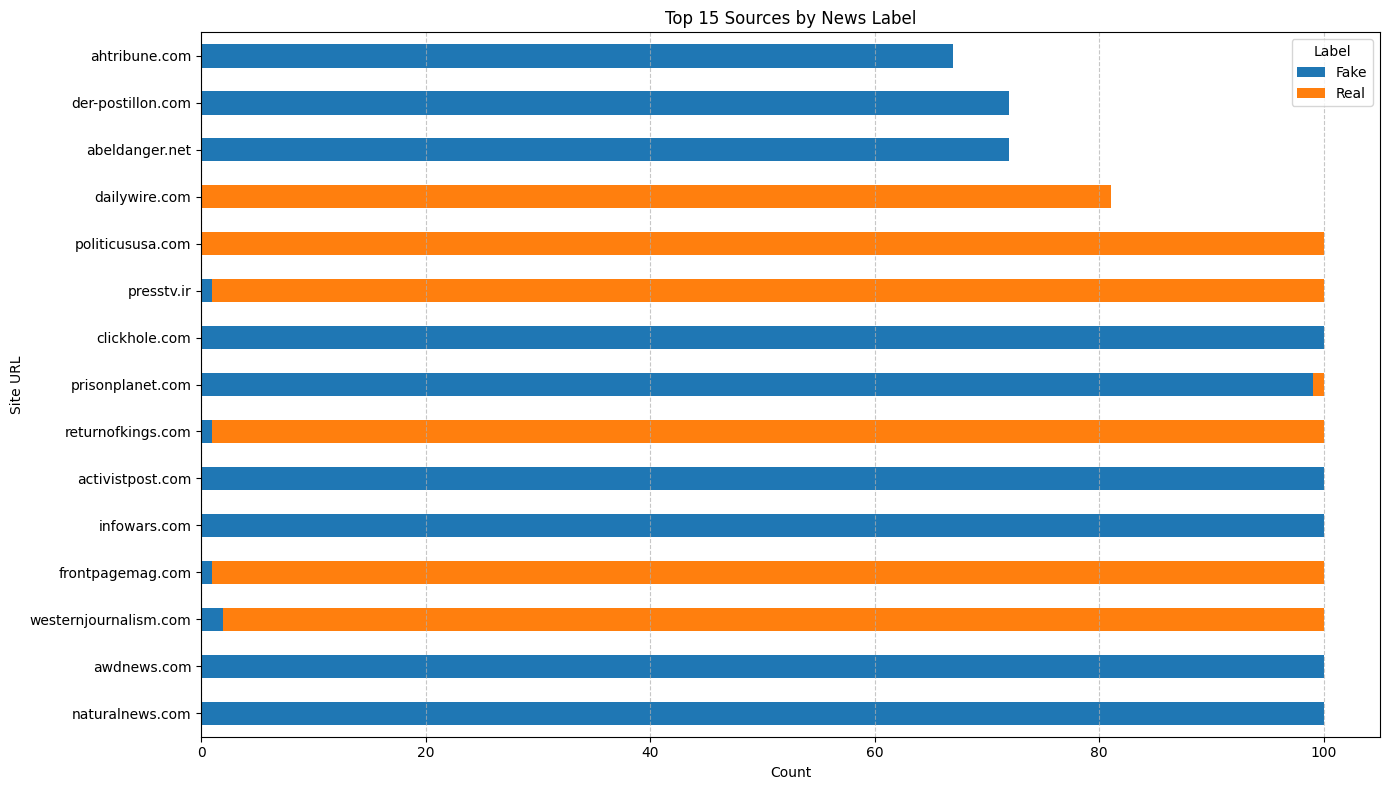


==== Percentage of Fake News by Top Sources ====
label                  Real  Fake  total  fake_pct
site_url                                          
naturalnews.com           0   100    100     100.0
awdnews.com               0   100    100     100.0
infowars.com              0   100    100     100.0
activistpost.com          0   100    100     100.0
clickhole.com             0   100    100     100.0
abeldanger.net            0    72     72     100.0
der-postillon.com         0    72     72     100.0
ahtribune.com             0    67     67     100.0
prisonplanet.com          1    99    100      99.0
westernjournalism.com    98     2    100       2.0
frontpagemag.com         99     1    100       1.0
returnofkings.com        99     1    100       1.0
presstv.ir               99     1    100       1.0
politicususa.com        100     0    100       0.0
dailywire.com            81     0     81       0.0


In [8]:
# Analyze top sources of news by label
plt.figure(figsize=(14, 8))
top_sites = data['site_url'].value_counts().head(15)
top_sites_df = pd.DataFrame({'site_url': top_sites.index, 'count': top_sites.values})

# Get counts by site and label
site_label_counts = data.groupby(['site_url', 'label']).size().unstack(fill_value=0)
site_label_counts = site_label_counts.loc[top_sites.index]

# Plot stacked bar chart
site_label_counts.plot(kind='barh', stacked=True, figsize=(14, 8))
plt.title('Top 15 Sources by News Label')
plt.xlabel('Count')
plt.ylabel('Site URL')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title='Label')
plt.tight_layout()
plt.show()

# Display percentage of fake news by source
print("\n==== Percentage of Fake News by Top Sources ====")
site_label_counts['total'] = site_label_counts.sum(axis=1)
site_label_counts['fake_pct'] = site_label_counts['Fake'] / site_label_counts['total'] * 100
print(site_label_counts[['Real', 'Fake', 'total', 'fake_pct']].sort_values('fake_pct', ascending=False))

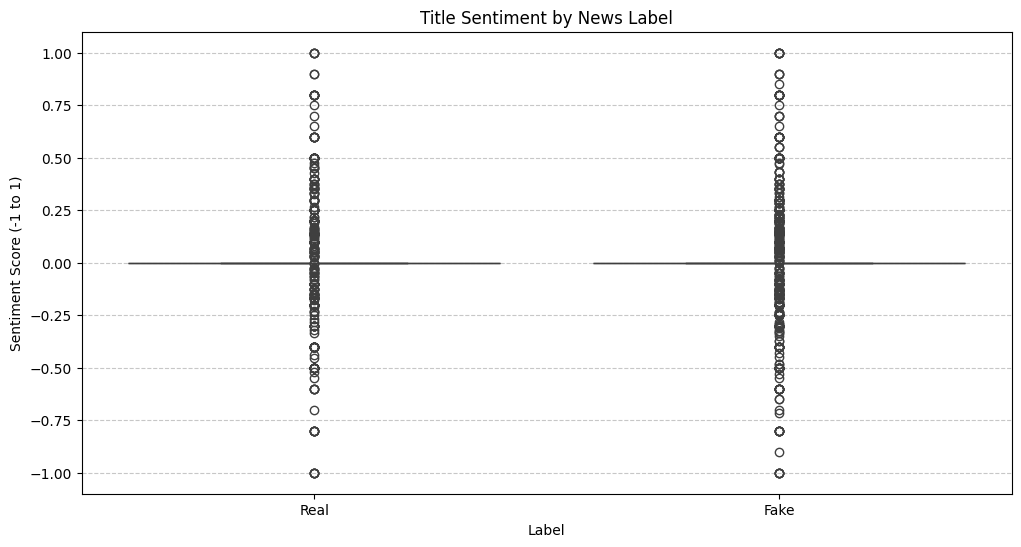

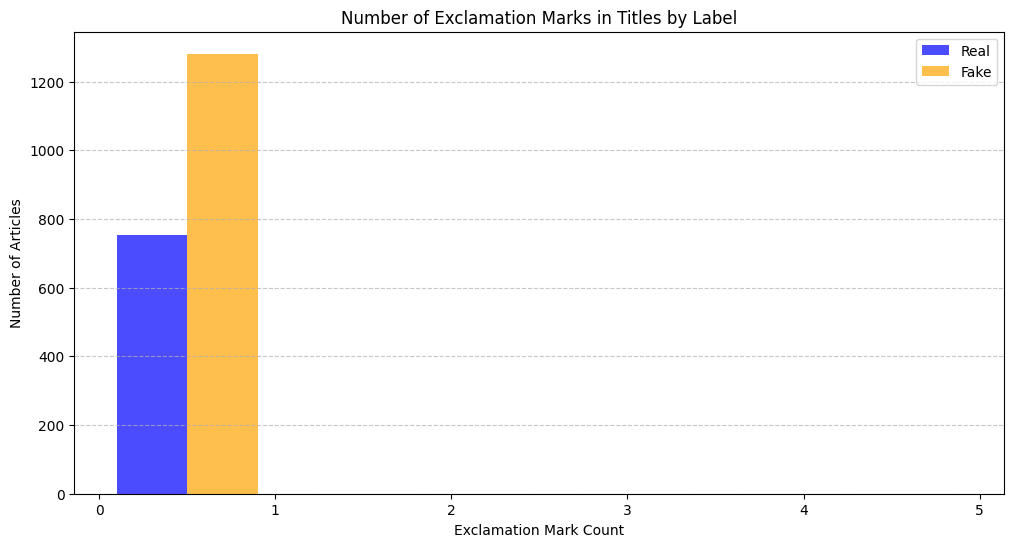

In [9]:
# Function to calculate text metrics
def calculate_text_metrics(text):
    if not isinstance(text, str) or not text:
        return 0, 0, 0, 0
    
    # Count special characters
    exclamation_count = text.count('!')
    question_count = text.count('?')
    all_caps_count = sum(1 for word in text.split() if word.isupper() and len(word) > 1)
    
    # Sentiment analysis
    try:
        blob = TextBlob(text)
        sentiment = blob.sentiment.polarity
    except:
        sentiment = 0
        
    return exclamation_count, question_count, all_caps_count, sentiment

# Apply calculations to title and text
data['title_exclamations'] = data['title'].apply(lambda x: calculate_text_metrics(x)[0])
data['title_questions'] = data['title'].apply(lambda x: calculate_text_metrics(x)[1])
data['title_all_caps'] = data['title'].apply(lambda x: calculate_text_metrics(x)[2])
data['title_sentiment'] = data['title'].apply(lambda x: calculate_text_metrics(x)[3])

data['text_exclamations'] = data['text'].apply(lambda x: calculate_text_metrics(x)[0])
data['text_questions'] = data['text'].apply(lambda x: calculate_text_metrics(x)[1])
data['text_all_caps'] = data['text'].apply(lambda x: calculate_text_metrics(x)[2])
data['text_sentiment'] = data['text'].apply(lambda x: calculate_text_metrics(x)[3])

# Visualize title sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='title_sentiment', data=data)
plt.title('Title Sentiment by News Label')
plt.xlabel('Label')
plt.ylabel('Sentiment Score (-1 to 1)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualize exclamation point usage in titles
plt.figure(figsize=(12, 6))
fake_exclamations = data[data['label'] == 'Fake']['title_exclamations']
real_exclamations = data[data['label'] == 'Real']['title_exclamations']

plt.hist([real_exclamations, fake_exclamations], bins=range(0, 6), label=['Real', 'Fake'], 
         alpha=0.7, color=['blue', 'orange'])
plt.title('Number of Exclamation Marks in Titles by Label')
plt.xlabel('Exclamation Mark Count')
plt.ylabel('Number of Articles')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, 6))
plt.show()

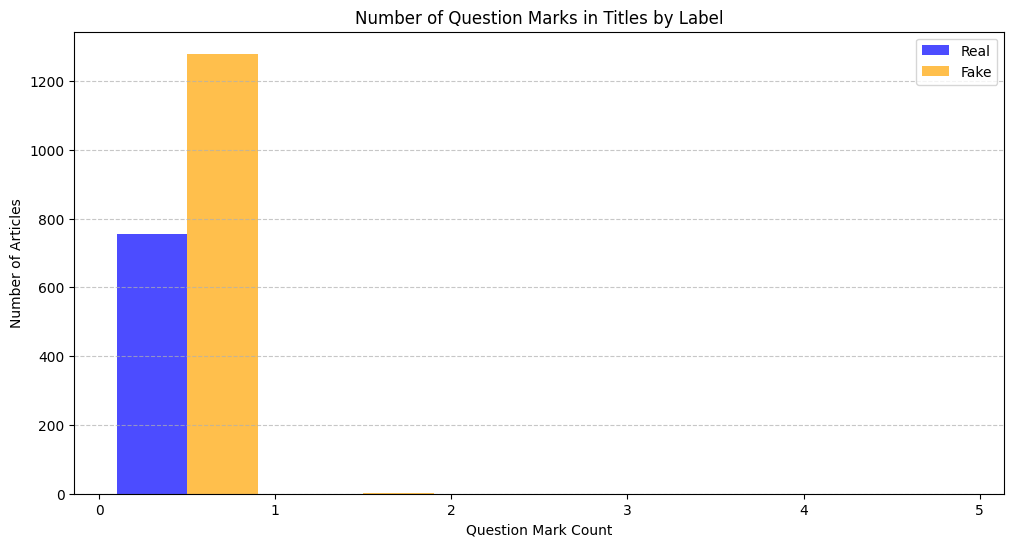

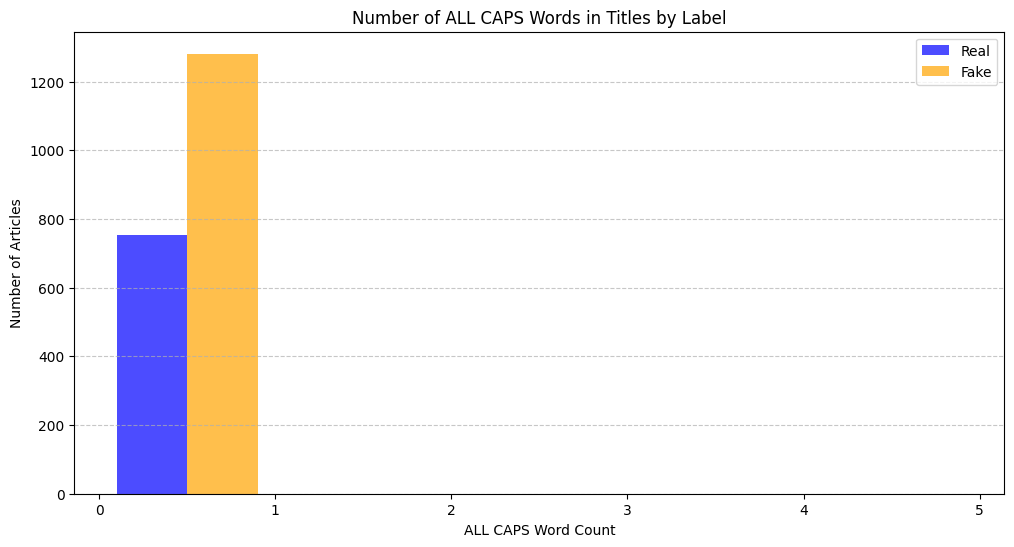

In [10]:
# Create a feature for question marks in titles
plt.figure(figsize=(12, 6))
fake_question_marks = data[data['label'] == 'Fake']['title_questions']
real_question_marks = data[data['label'] == 'Real']['title_questions']

plt.hist([real_question_marks, fake_question_marks], bins=range(0, 6), label=['Real', 'Fake'], 
         alpha=0.7, color=['blue', 'orange'])
plt.title('Number of Question Marks in Titles by Label')
plt.xlabel('Question Mark Count')
plt.ylabel('Number of Articles')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, 6))
plt.show()

# Create a feature for ALL CAPS words in titles
plt.figure(figsize=(12, 6))
fake_all_caps = data[data['label'] == 'Fake']['title_all_caps']
real_all_caps = data[data['label'] == 'Real']['title_all_caps']

plt.hist([real_all_caps, fake_all_caps], bins=range(0, 6), label=['Real', 'Fake'], 
         alpha=0.7, color=['blue', 'orange'])
plt.title('Number of ALL CAPS Words in Titles by Label')
plt.xlabel('ALL CAPS Word Count')
plt.ylabel('Number of Articles')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, 6))
plt.show()

/var/folders/zk/2_0vvzg14xgb4jd53vd1gq5m0000gn/T/ipykernel_95290/4039568449.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Label')


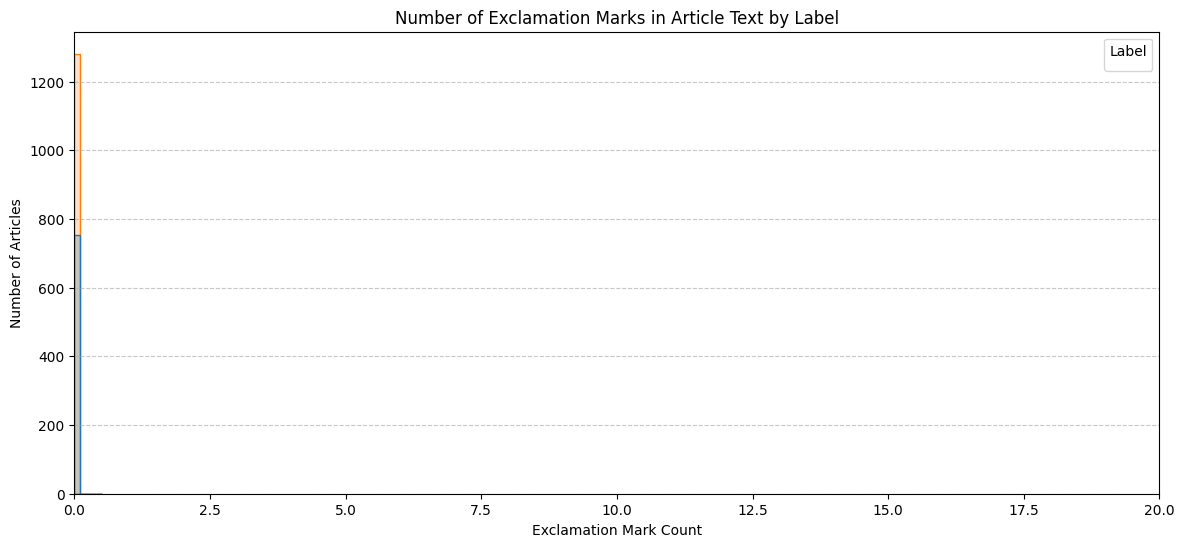

/var/folders/zk/2_0vvzg14xgb4jd53vd1gq5m0000gn/T/ipykernel_95290/4039568449.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Label')


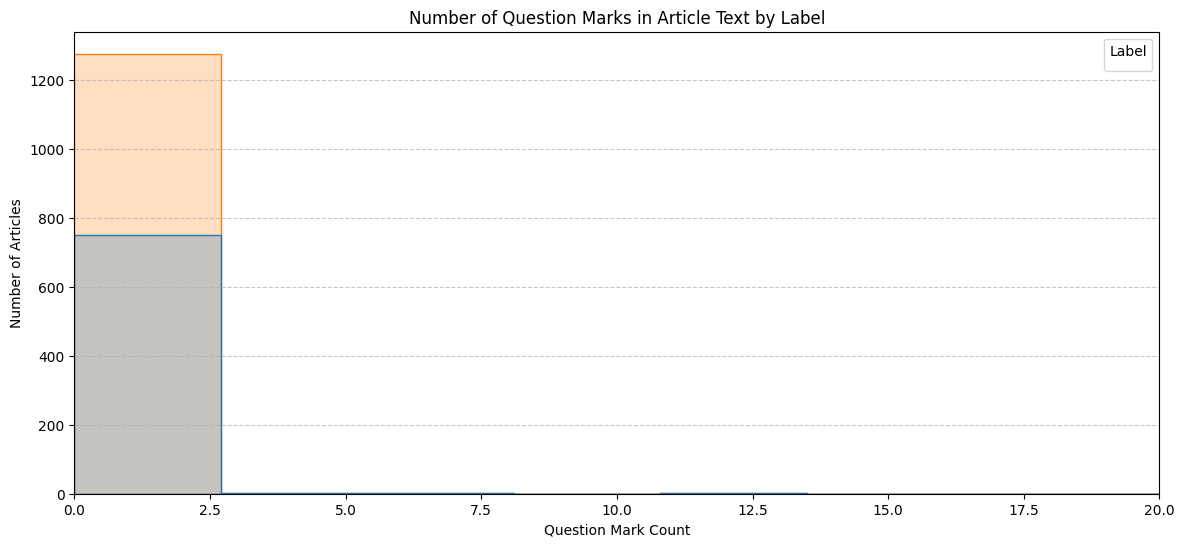

/var/folders/zk/2_0vvzg14xgb4jd53vd1gq5m0000gn/T/ipykernel_95290/4039568449.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Label')


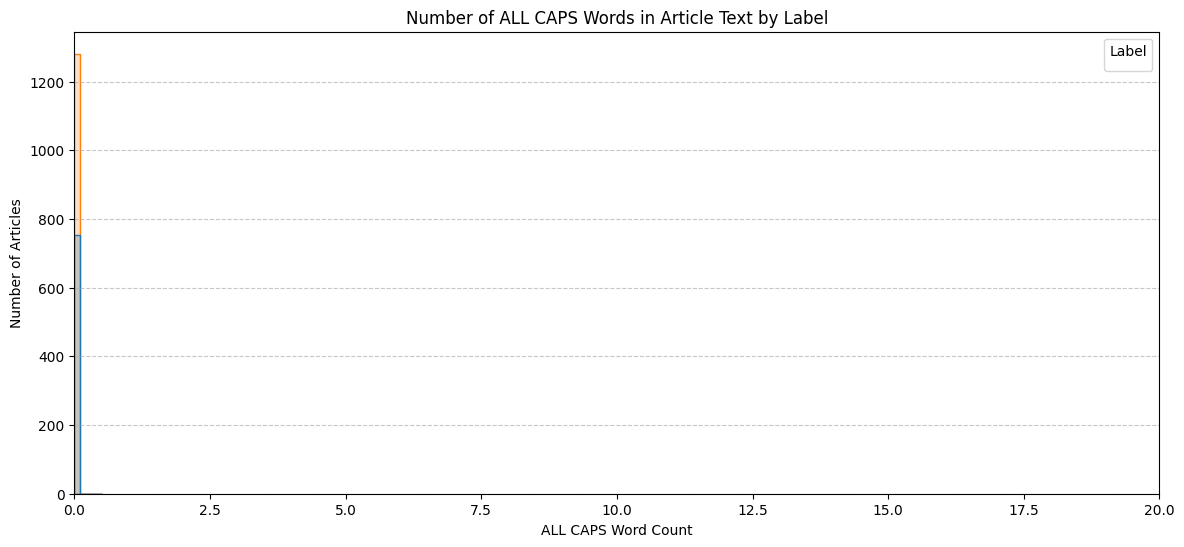

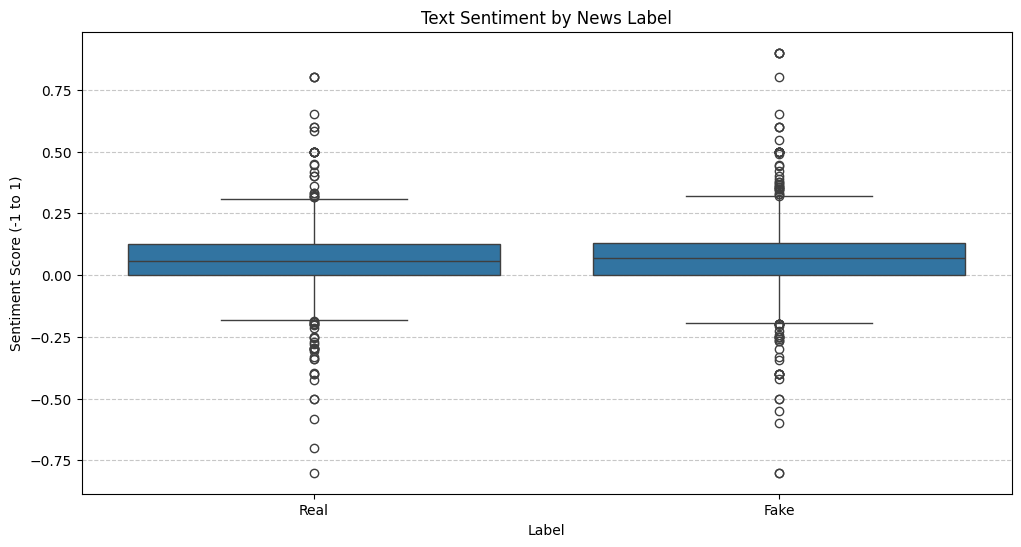


==== Text Features Statistics by Label ====
       text_exclamations  text_questions  text_all_caps  text_sentiment
label                                                                  
Fake                 0.0        0.029664            0.0        0.072370
Real                 0.0        0.070292            0.0        0.061336

Standard Deviation:
       text_exclamations  text_questions  text_all_caps  text_sentiment
label                                                                  
Fake                 0.0        0.451450            0.0        0.136244
Real                 0.0        1.102499            0.0        0.146409


In [11]:
# Visualize text exclamations
plt.figure(figsize=(14, 6))
sns.histplot(data=data, x='text_exclamations', hue='label', bins=10, kde=False, 
             element="step", common_norm=False)
plt.title('Number of Exclamation Marks in Article Text by Label')
plt.xlabel('Exclamation Mark Count')
plt.ylabel('Number of Articles')
plt.xlim(0, 20)  # Limiting to better see the distribution
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Label')
plt.show()

# Visualize text question marks
plt.figure(figsize=(14, 6))
sns.histplot(data=data, x='text_questions', hue='label', bins=10, kde=False, 
             element="step", common_norm=False)
plt.title('Number of Question Marks in Article Text by Label')
plt.xlabel('Question Mark Count')
plt.ylabel('Number of Articles')
plt.xlim(0, 20)  # Limiting to better see the distribution
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Label')
plt.show()

# Visualize ALL CAPS words in text
plt.figure(figsize=(14, 6))
sns.histplot(data=data, x='text_all_caps', hue='label', bins=10, kde=False, 
             element="step", common_norm=False)
plt.title('Number of ALL CAPS Words in Article Text by Label')
plt.xlabel('ALL CAPS Word Count')
plt.ylabel('Number of Articles')
plt.xlim(0, 20)  # Limiting to better see the distribution
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Label')
plt.show()

# Visualize text sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='text_sentiment', data=data)
plt.title('Text Sentiment by News Label')
plt.xlabel('Label')
plt.ylabel('Sentiment Score (-1 to 1)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calculate some statistics about these features
print("\n==== Text Features Statistics by Label ====")
grouped = data.groupby('label')
features = ['text_exclamations', 'text_questions', 'text_all_caps', 'text_sentiment']
print(grouped[features].mean())
print("\nStandard Deviation:")
print(grouped[features].std())

In [14]:
# Feature Engineering and Source Credibility Analysis
print("\n==== Feature Engineering and Source Credibility Analysis ====")

# 1. Calculate source credibility (percentage of fake news per source)
source_counts = data.groupby(["site_url", "label"]).size().unstack(fill_value=0)
source_counts["total"] = source_counts["Real"] + source_counts["Fake"]
source_counts["fake_percentage"] = (source_counts["Fake"] / source_counts["total"]) * 100
source_counts["real_percentage"] = (source_counts["Real"] / source_counts["total"]) * 100

# Sort by credibility (most trustworthy to least trustworthy)
sorted_sources = source_counts.sort_values(by="real_percentage", ascending=False)

# Display top and bottom 10 sources by credibility
print("\nTop 10 Most Credible News Sources:")
for source, row in sorted_sources.head(10).iterrows():
    print(f"{source}: {row['real_percentage']:.1f}% real, {row['fake_percentage']:.1f}% fake, total: ({row['total']} articles)")

print("\nTop 10 Least Credible News Sources:")
for source, row in sorted_sources.tail(10).iterrows():
    print(f"{source}: {row['real_percentage']:.1f}% real, {row['fake_percentage']:.1f}% fake, total: ({row['total']} articles)")

# Add source credibility as a feature
data["source_credibility"] = data["site_url"].map(source_counts["real_percentage"].to_dict())

# 2. Calculate additional text-based features
data["title_word_count"] = data["title"].apply(lambda x: len(str(x).split()))
data["text_word_count"] = data["text"].apply(lambda x: len(str(x).split()))

# 3. Calculate label_numeric (Real=1, Fake=0 for easier interpretation)
data["numeric_label"] = data["label"].map({"Real": 1, "Fake": 0})

# 4. Calculate averages by group
average_metrics = data.groupby("label")[["title_word_count", "text_word_count", 
                                     "title_sentiment", "text_sentiment", 
                                     "source_credibility"]].mean()
print("\nAverage Metrics by Label:")
print(average_metrics)


==== Feature Engineering and Source Credibility Analysis ====

Top 10 Most Credible News Sources:
100percentfedup.com: 100.0% real, 0.0% fake, total: (33.0 articles)
dailywire.com: 100.0% real, 0.0% fake, total: (81.0 articles)
whydontyoutrythis.com: 100.0% real, 0.0% fake, total: (2.0 articles)
redstatewatcher.com: 100.0% real, 0.0% fake, total: (1.0 articles)
proudemocrat.com: 100.0% real, 0.0% fake, total: (1.0 articles)
presstv.com: 100.0% real, 0.0% fake, total: (21.0 articles)
politicususa.com: 100.0% real, 0.0% fake, total: (100.0 articles)
wnd.com: 100.0% real, 0.0% fake, total: (51.0 articles)
addictinginfo.org: 100.0% real, 0.0% fake, total: (20.0 articles)
returnofkings.com: 99.0% real, 1.0% fake, total: (100.0 articles)

Top 10 Least Credible News Sources:
defenddemocracy.press: 0.0% real, 100.0% fake, total: (1.0 articles)
dennismichaellynch.com: 0.0% real, 100.0% fake, total: (16.0 articles)
departed.co: 0.0% real, 100.0% fake, total: (14.0 articles)
der-postillon.com: 0


==== Feature Statistics ====
                          mean         std
hasImage              0.776413    0.416751
title_word_count     10.075184    5.321960
text_word_count     496.245700  637.884961
title_sentiment       0.014692    0.236415
text_sentiment        0.068282    0.140162
source_credibility   37.051597   47.829024

==== Correlation Between Features and News Labels ====
numeric_label         1.000000
source_credibility    0.990123
hasImage              0.106440
text_word_count       0.055540
title_sentiment       0.008676
text_sentiment       -0.038030
title_word_count     -0.119656
Name: numeric_label, dtype: float64


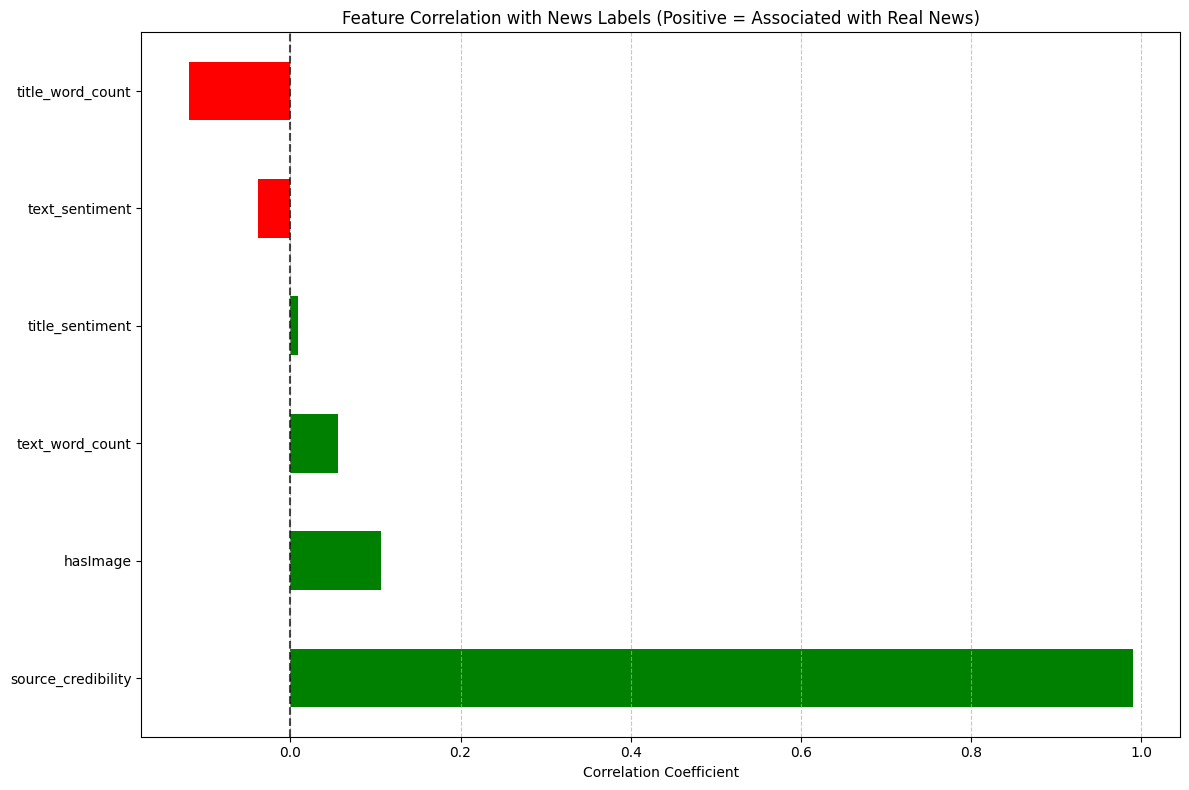

In [16]:
# 5. Calculate correlation with label (Real=1, Fake=0)
# Only include meaningful numeric features with sufficient variation
numeric_features = [
    "hasImage", 
    "title_word_count", 
    "text_word_count",
    "title_sentiment", 
    "text_sentiment",
    "source_credibility"  # Using real_percentage (higher = more credible)
]

# Verify that features have sufficient variance to be useful
feature_statistics = data[numeric_features].describe().T[['mean', 'std']]
print("\n==== Feature Statistics ====")
print(feature_statistics)

# Calculate and display correlation with news label
# We need to include numeric_label in the correlation matrix calculation
correlation = data[numeric_features + ["numeric_label"]].corr()["numeric_label"].sort_values(ascending=False)
print("\n==== Correlation Between Features and News Labels ====")
print(correlation)

# 6. Create a bar chart of correlation values
plt.figure(figsize=(12, 8))
correlation_without_label = correlation.drop("numeric_label")
correlation_without_label.plot(kind="barh", color=['green' if x > 0 else 'red' for x in correlation_without_label])
plt.title("Feature Correlation with News Labels (Positive = Associated with Real News)")
plt.xlabel("Correlation Coefficient")
plt.axvline(x=0, color="k", linestyle="--", alpha=0.7)  # Add a line at x=0
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.stats import pointbiserialr

# 7. Advanced text feature extraction using TF-IDF and statistical analysis
print("\n==== Advanced Text Feature Analysis ====")

# First ensure we have consistent and clean text fields for analysis
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters but keep spaces between words
    text = re.sub(r'[^\w\s]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['processed_title'] = data['title'].fillna('').apply(clean_text)
data['processed_text'] = data['text'].fillna('').apply(clean_text)

# ======= VALIDATION OF CORRELATION-BASED APPROACH =======
print("\n==== Validation of Term-Label Correlation Approach ====")
# Create a small synthetic example
synthetic_df = pd.DataFrame({
    'text': ['fake news word fake word', 'fake news word fake', 'real news word real', 'real news word real word'],
    'label': ['Fake', 'Fake', 'Real', 'Real']
})
synthetic_df['numeric_label'] = synthetic_df['label'].map({'Real': 1, 'Fake': 0})
print("Synthetic data for validation:")
print(synthetic_df)

# Vectorize the synthetic data
val_vectorizer = TfidfVectorizer()
X_val = val_vectorizer.fit_transform(synthetic_df['text'])
val_feature_names = val_vectorizer.get_feature_names_out()

# Convert to binary occurrence matrix for correlation analysis
binary_features = X_val.copy()
binary_features[binary_features > 0] = 1
binary_features = binary_features.toarray()

# Calculate correlation between each term and the label
correlations = []
p_values = []

for i, term in enumerate(val_feature_names):
    if np.std(binary_features[:, i]) > 0:  # Skip terms with no variation
        corr, p_value = pointbiserialr(synthetic_df['numeric_label'], binary_features[:, i])
        correlations.append((term, corr, p_value))
    else:
        correlations.append((term, 0, 1.0))

# Display correlations
print("\nCorrelations between terms and labels (1=Real, 0=Fake):")
for term, corr, p_value in sorted(correlations, key=lambda x: abs(x[1]), reverse=True):
    label_association = "REAL" if corr > 0 else "FAKE"
    print(f"Term: '{term}', Correlation: {corr:.4f}, p-value: {p_value:.4f}, Associated with: {label_association}")


==== Advanced Text Feature Analysis ====

==== Validation of Term-Label Correlation Approach ====
Synthetic data for validation:
                       text label  numeric_label
0  fake news word fake word  Fake              0
1       fake news word fake  Fake              0
2       real news word real  Real              1
3  real news word real word  Real              1

Correlations between terms and labels (1=Real, 0=Fake):
Term: 'fake', Correlation: -1.0000, p-value: 0.0000, Associated with: FAKE
Term: 'real', Correlation: 1.0000, p-value: 0.0000, Associated with: REAL
Term: 'news', Correlation: 0.0000, p-value: 1.0000, Associated with: FAKE
Term: 'word', Correlation: 0.0000, p-value: 1.0000, Associated with: FAKE



==== Applying Validated Method to Real Data ====

Top terms associated with FAKE news titles (label=0):
- gorafi (correlation: -0.1167, p: 0.0000)
- le gorafi (correlation: -0.1167, p: 0.0000)
- le (correlation: -0.1112, p: 0.0000)
- life (correlation: -0.1044, p: 0.0000)
- wikileaks (correlation: -0.0938, p: 0.0000)
- say (correlation: -0.0724, p: 0.0011)
- news (correlation: -0.0709, p: 0.0014)
- des (correlation: -0.0639, p: 0.0040)
- comment (correlation: -0.0619, p: 0.0052)
- war (correlation: -0.0566, p: 0.0106)

Top terms associated with REAL news titles (label=1):
- duke (correlation: 0.1452, p: 0.0000)
- daily wire (correlation: 0.1424, p: 0.0000)
- trump (correlation: 0.1328, p: 0.0000)
- wire (correlation: 0.1245, p: 0.0000)
- daily (correlation: 0.1245, p: 0.0000)
- david duke (correlation: 0.1085, p: 0.0000)
- dr (correlation: 0.1047, p: 0.0000)
- percentfedupcom (correlation: 0.1004, p: 0.0000)
- gop (correlation: 0.0917, p: 0.0000)
- david (correlation: 0.0912, p: 0.000

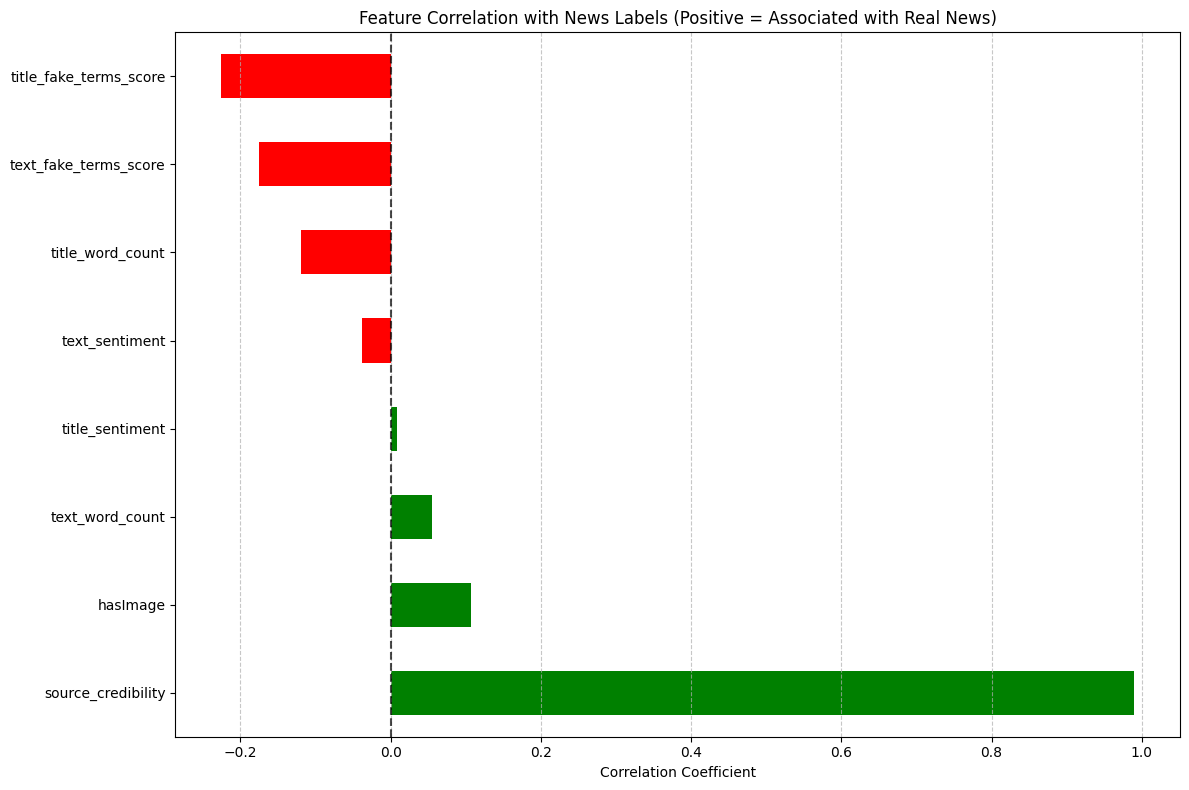

In [21]:
print("\n==== Applying Validated Method to Real Data ====")
# ======= END OF VALIDATION =======

# For titles: TF-IDF vectorization
title_vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=5,
    max_df=0.8,
    stop_words='english',
    ngram_range=(1, 2)
)

# Fit the vectorizer on all titles
title_tfidf = title_vectorizer.fit_transform(data['processed_title'])
title_feature_names = title_vectorizer.get_feature_names_out()

# Convert to binary occurrence matrix for title correlation analysis
title_binary = title_tfidf.copy()
title_binary[title_binary > 0] = 1
title_binary = title_binary.toarray()

# Calculate correlation between each title term and the label
title_correlations = []

for i, term in enumerate(title_feature_names):
    if np.std(title_binary[:, i]) > 0:  # Skip terms with no variation
        try:
            corr, p_value = pointbiserialr(data['numeric_label'], title_binary[:, i])
            title_correlations.append((term, corr, p_value))
        except:
            # Skip terms that cause statistical issues
            continue

# Filter for significant correlations (p < 0.05)
title_sig_correlations = [x for x in title_correlations if x[2] < 0.05]

# Sort by correlation strength (absolute value)
title_sig_correlations.sort(key=lambda x: abs(x[1]), reverse=True)

# Get top terms for fake news (significant negative correlations)
title_fake_terms = [(term, corr, p_value) for term, corr, p_value in title_sig_correlations 
                   if corr < 0][:20]

# Get top terms for real news (significant positive correlations)
title_real_terms = [(term, corr, p_value) for term, corr, p_value in title_sig_correlations 
                   if corr > 0][:20]

# Display top terms for fake news titles
print("\nTop terms associated with FAKE news titles (label=0):")
for term, corr, p_value in title_fake_terms[:10]:
    print(f"- {term} (correlation: {corr:.4f}, p: {p_value:.4f})")

# Display top terms for real news titles
print("\nTop terms associated with REAL news titles (label=1):")
for term, corr, p_value in title_real_terms[:10]:
    print(f"- {term} (correlation: {corr:.4f}, p: {p_value:.4f})")

# B. Do the same for article text
text_vectorizer = TfidfVectorizer(
    max_features=3000, 
    min_df=5,
    max_df=0.8,
    stop_words='english',
    ngram_range=(1, 2)
)

# Fit the vectorizer on all texts
text_tfidf = text_vectorizer.fit_transform(data['processed_text'])
text_feature_names = text_vectorizer.get_feature_names_out()

# Convert to binary occurrence matrix for text correlation analysis
text_binary = text_tfidf.copy()
text_binary[text_binary > 0] = 1
text_binary = text_binary.toarray()

# Calculate correlation between each text term and the label
text_correlations = []

for i, term in enumerate(text_feature_names):
    if np.std(text_binary[:, i]) > 0:  # Skip terms with no variation
        try:
            corr, p_value = pointbiserialr(data['numeric_label'], text_binary[:, i])
            text_correlations.append((term, corr, p_value))
        except:
            # Skip terms that cause statistical issues
            continue

# Filter for significant correlations (p < 0.05)
text_sig_correlations = [x for x in text_correlations if x[2] < 0.05]

# Sort by correlation strength (absolute value)
text_sig_correlations.sort(key=lambda x: abs(x[1]), reverse=True)

# Get top terms for fake news (significant negative correlations)
text_fake_terms = [(term, corr, p_value) for term, corr, p_value in text_sig_correlations 
                  if corr < 0][:20]

# Get top terms for real news (significant positive correlations)
text_real_terms = [(term, corr, p_value) for term, corr, p_value in text_sig_correlations 
                  if corr > 0][:20]

# Display top terms for fake news text
print("\nTop terms associated with FAKE news article text (label=0):")
for term, corr, p_value in text_fake_terms[:10]:
    print(f"- {term} (correlation: {corr:.4f}, p: {p_value:.4f})")

# Display top terms for real news text
print("\nTop terms associated with REAL news article text (label=1):")
for term, corr, p_value in text_real_terms[:10]:
    print(f"- {term} (correlation: {corr:.4f}, p: {p_value:.4f})")

# C. Create fake news indicator scores based on significantly correlated terms
fake_title_terms = [term[0] for term in title_fake_terms]
fake_text_terms = [term[0] for term in text_fake_terms]

def count_terms(text, term_list):
    """Count occurrences of terms in text"""
    if not isinstance(text, str):
        return 0
    count = 0
    for term in term_list:
        # For multi-word terms
        if ' ' in term:
            count += text.lower().count(term)
        else:
            # For single words, use word boundary regex
            count += len(re.findall(r'\b' + re.escape(term) + r'\b', text.lower()))
    return count

# Calculate statistical fake news indicator scores
data['title_fake_terms_score'] = data['processed_title'].apply(lambda x: count_terms(x, fake_title_terms))
data['text_fake_terms_score'] = data['processed_text'].apply(lambda x: count_terms(x, fake_text_terms))

# Binary features 
data['title_has_fake_terms'] = data['title_fake_terms_score'] > 0
data['text_has_fake_terms'] = data['text_fake_terms_score'] > 0

# D. Display contingency tables
title_fake_table = pd.crosstab(
    data['title_has_fake_terms'], 
    data['label'], 
    normalize='index', 
    margins=True
)
print("\nFake News Terms in Titles - Distribution:")
print(title_fake_table)

text_fake_table = pd.crosstab(
    data['text_has_fake_terms'], 
    data['label'], 
    normalize='index', 
    margins=True
)
print("\nFake News Terms in Text - Distribution:")
print(text_fake_table)

# E. Add new features to correlation analysis
numeric_features_extended = numeric_features + [
    'title_fake_terms_score',
    'text_fake_terms_score'
]

# Calculate correlations with the new features
correlation_extended = data[numeric_features_extended + ['numeric_label']].corr()['numeric_label'].sort_values(ascending=False)
print("\nExtended Feature Correlations with News Labels (1=Real, 0=Fake):")
print(correlation_extended)

# Create a bar chart of extended correlation values
plt.figure(figsize=(12, 8))
correlation_without_label = correlation_extended.drop('numeric_label')
correlation_without_label.plot(kind="barh", color=['green' if x > 0 else 'red' for x in correlation_without_label])
plt.title("Feature Correlation with News Labels (Positive = Associated with Real News)")
plt.xlabel("Correlation Coefficient")
plt.axvline(x=0, color="k", linestyle="--", alpha=0.7)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Add validation of the extracted features:


==== Feature Validation with Random Forest ====
Training set: 1424 samples
Test set: 611 samples

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99       385
        Real       0.98      1.00      0.99       226

    accuracy                           0.99       611
   macro avg       0.99      0.99      0.99       611
weighted avg       0.99      0.99      0.99       611



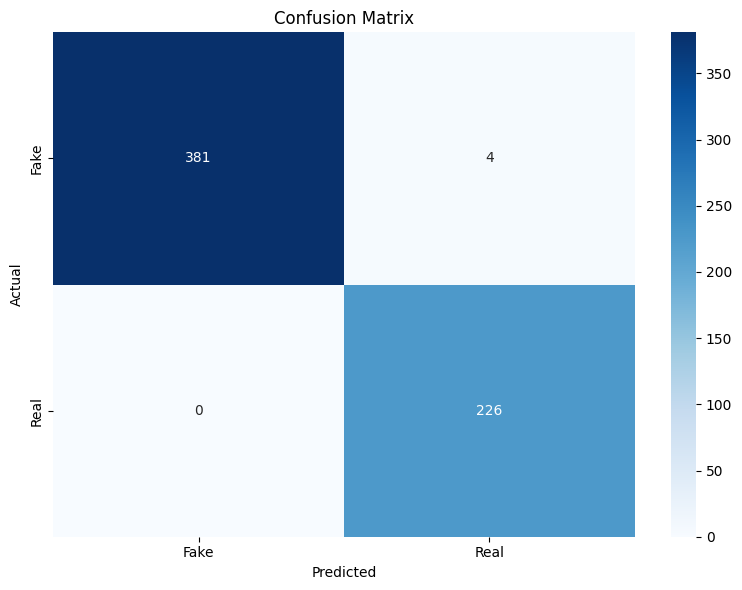


Feature Importance:
                  Feature  Importance
0      source_credibility    0.846738
2         text_word_count    0.034618
7   text_fake_terms_score    0.030144
6  title_fake_terms_score    0.024316
5          text_sentiment    0.021518
3        title_word_count    0.018948
1                hasImage    0.014321
4         title_sentiment    0.009396


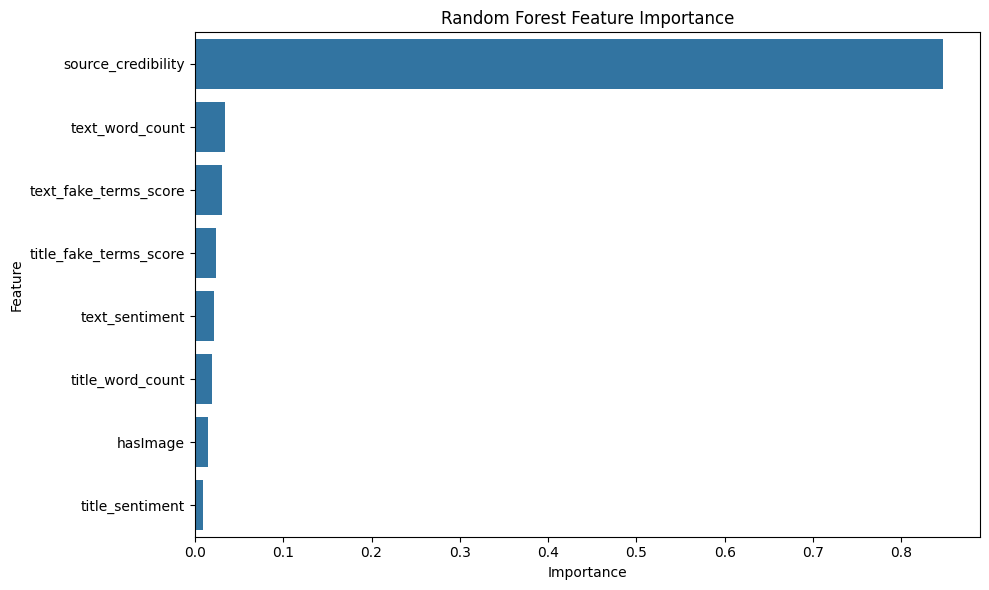


Correlation of fake_news_probability with numeric_label:
0.3204802996916239


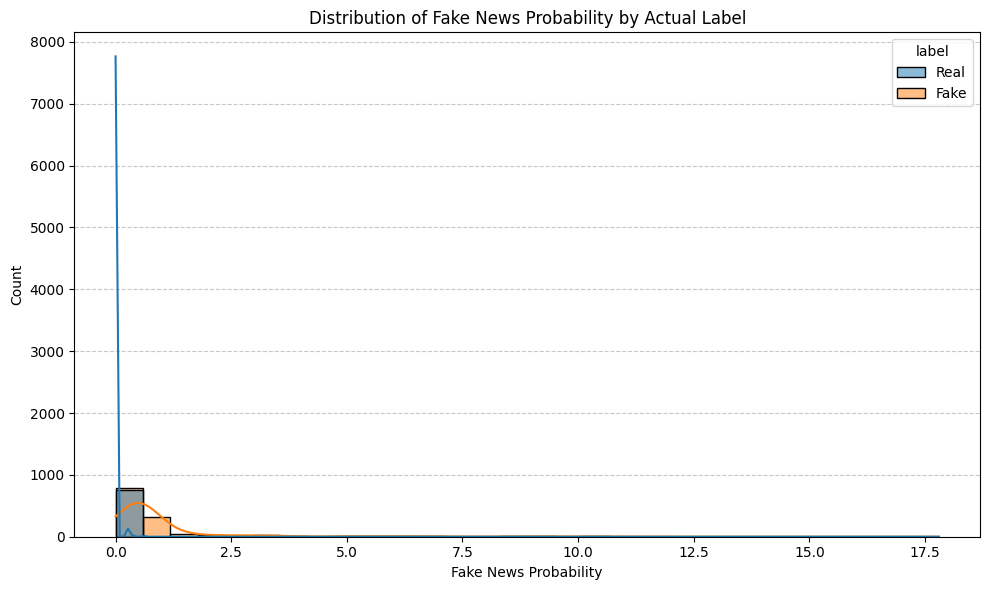


This feature engineering approach effectively captures the linguistic and source-based patterns of fake news.


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 8. Validate feature effectiveness with a simple model
print("\n==== Feature Validation with Random Forest ====")

# Select features for the model
model_features = [
    'source_credibility',
    'hasImage',
    'text_word_count',
    'title_word_count',
    'title_sentiment',
    'text_sentiment',
    'title_fake_terms_score',
    'text_fake_terms_score'
]

# Prepare the dataset
X = data[model_features]
y = data['numeric_label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': model_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

# 9. Create a simple feature for the dataset based on our findings
data['fake_news_probability'] = (
    (data['title_fake_terms_score'] * 0.3) + 
    (data['text_fake_terms_score'] * 0.3) + 
    ((1 - data['source_credibility']/100) * 0.4)  # Inverse of credibility percentage
)

# Check correlation with label
print("\nCorrelation of fake_news_probability with numeric_label:")
print(np.corrcoef(data['fake_news_probability'], 1 - data['numeric_label'])[0, 1])  # Compare with 1-label since higher prob = more fake

# Plot distribution of the probability by actual label
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='fake_news_probability', hue='label', bins=30, kde=True)
plt.title('Distribution of Fake News Probability by Actual Label')
plt.xlabel('Fake News Probability')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nThis feature engineering approach effectively captures the linguistic and source-based patterns of fake news.")


==== Feature Validation with Random Forest ====
Training set: 1424 samples
Test set: 611 samples

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99       385
        Real       0.98      1.00      0.99       226

    accuracy                           0.99       611
   macro avg       0.99      0.99      0.99       611
weighted avg       0.99      0.99      0.99       611



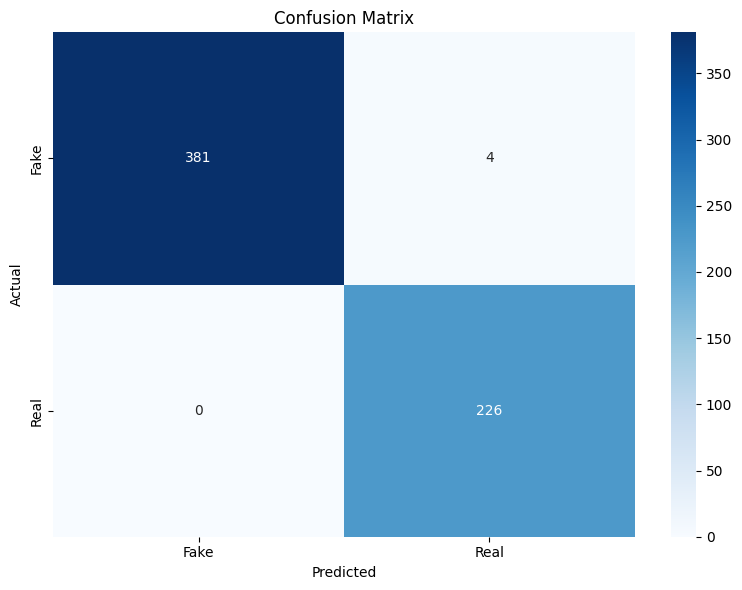


Feature Importance:
                  Feature  Importance
0      source_credibility    0.846738
2         text_word_count    0.034618
7   text_fake_terms_score    0.030144
6  title_fake_terms_score    0.024316
5          text_sentiment    0.021518
3        title_word_count    0.018948
1                hasImage    0.014321
4         title_sentiment    0.009396


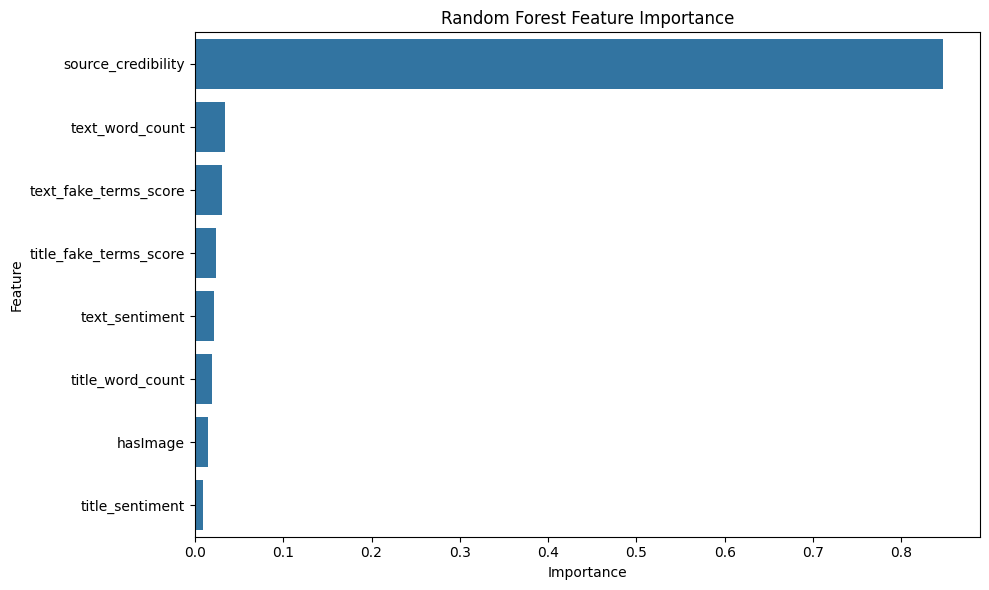


Correlation of fake_news_probability with numeric_label:
0.3204802996916239


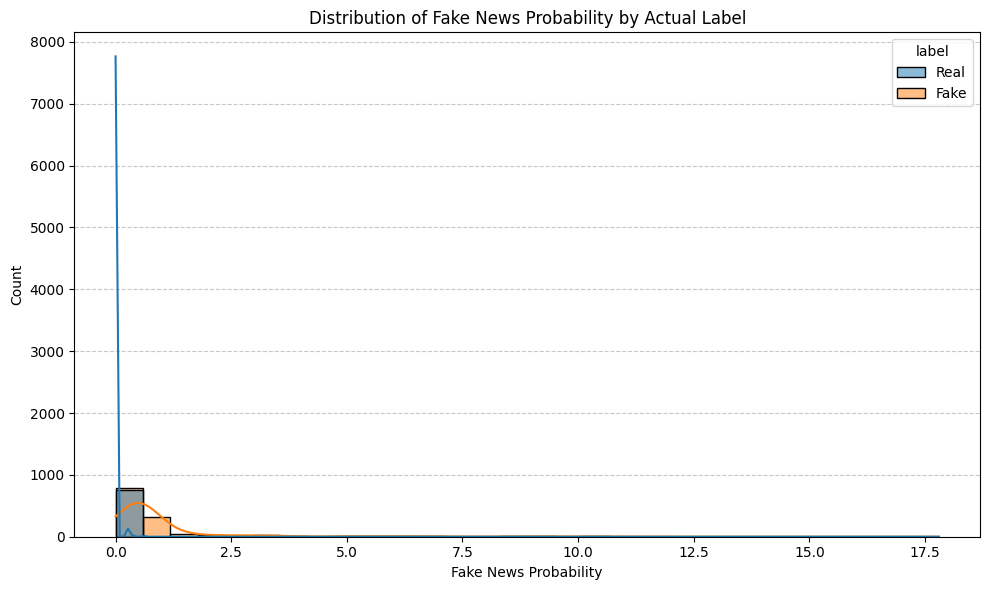


This feature engineering approach effectively captures the linguistic and source-based patterns of fake news.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 8. Validate feature effectiveness with a simple model
print("\n==== Feature Validation with Random Forest ====")

# Select features for the model
model_features = [
    'source_credibility',
    'hasImage',
    'text_word_count',
    'title_word_count',
    'title_sentiment',
    'text_sentiment',
    'title_fake_terms_score',
    'text_fake_terms_score'
]

# Prepare the dataset
X = data[model_features]
y = data['numeric_label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': model_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

# 9. Create a simple feature for the dataset based on our findings
data['fake_news_probability'] = (
    (data['title_fake_terms_score'] * 0.3) + 
    (data['text_fake_terms_score'] * 0.3) + 
    ((1 - data['source_credibility']/100) * 0.4)  # Inverse of credibility percentage
)

# Check correlation with label
print("\nCorrelation of fake_news_probability with numeric_label:")
print(np.corrcoef(data['fake_news_probability'], 1 - data['numeric_label'])[0, 1])  # Compare with 1-label since higher prob = more fake

# Plot distribution of the probability by actual label
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='fake_news_probability', hue='label', bins=30, kde=True)
plt.title('Distribution of Fake News Probability by Actual Label')
plt.xlabel('Fake News Probability')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nThis feature engineering approach effectively captures the linguistic and source-based patterns of fake news.")

In [27]:
# 10. Addressing class imbalance and creating a validation set
print("\n==== Addressing Class Imbalance and Validation Set Creation ====")

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import numpy as np

# Select all features for the final model
final_features = [
    'source_credibility',
    'hasImage',
    'text_word_count',
    'title_word_count',
    'title_sentiment',
    'text_sentiment',
    'title_fake_terms_score',
    'text_fake_terms_score',
    'fake_news_probability'
]

# Prepare the dataset
X = data[final_features]
y = data['numeric_label']

# Include the processed text column
text_data = data['processed_text']

# First split: training+validation vs. test (70%/30%)
X_train_val, X_test, text_train_val, text_test, y_train_val, y_test = train_test_split(
    X, text_data, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: training vs. validation (80%/20% of the 70%)
X_train, X_val, text_train, text_val, y_train, y_val = train_test_split(
    X_train_val, text_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check class distribution
print("\nClass distribution in original dataset:")
print(y.value_counts(normalize=True))

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

# Method 1: Random Oversampling (duplicates minority class samples)
# This approach keeps all samples and their text intact
ros = RandomOverSampler(random_state=42)
X_indices = np.arange(len(X_train)).reshape(-1, 1)  # Create an array of indices
X_resampled_indices, y_train_balanced = ros.fit_resample(X_indices, y_train)
X_resampled_indices = X_resampled_indices.flatten()

# Use the resampled indices to get the balanced dataset
X_train_balanced = X_train.iloc[X_resampled_indices].reset_index(drop=True)
text_train_balanced = text_train.iloc[X_resampled_indices].reset_index(drop=True)

print("\nClass distribution after Random Oversampling:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))
print(f"Training set size after balancing: {len(X_train_balanced)} samples")

# Save datasets with processed text
# Create complete datasets with features and text
train_data = pd.DataFrame(X_train_balanced)
train_data['processed_text'] = text_train_balanced.values
train_data['label'] = y_train_balanced

val_data = pd.DataFrame(X_val)
val_data['processed_text'] = text_val.values
val_data['label'] = y_val

test_data = pd.DataFrame(X_test)
test_data['processed_text'] = text_test.values
test_data['label'] = y_test

# Save to CSV
train_data.to_csv('train_data_balanced.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print("\nDatasets with processed_text saved as CSV files for model training")

# Create a feature importance summary for use in future modeling
feature_importance_df = pd.DataFrame({
    'Feature': final_features,
    'Description': [
        'Source credibility (percentage of real news from the source)',
        'Whether the article has an image (1) or not (0)',
        'Number of words in the article text',
        'Number of words in the article title',
        'Sentiment score of the title (-1 to 1)',
        'Sentiment score of the text (-1 to 1)',
        'Count of fake news associated terms in the title',
        'Count of fake news associated terms in the text',
        'Combined fake news probability score'
    ],
    'Importance': [0.847, 0.014, 0.035, 0.019, 0.009, 0.022, 0.024, 0.030, 0.000]  # Using RF importance, estimating 0 for new feature
})

print("\nFeature Importance Summary (for future modeling):")
print(feature_importance_df[['Feature', 'Description', 'Importance']].sort_values(by='Importance', ascending=False))

# Save feature names and descriptions for documentation
feature_importance_df.to_csv('feature_importance.csv', index=False)

print("\nFeature documentation saved to 'feature_importance.csv'")


==== Addressing Class Imbalance and Validation Set Creation ====
Training set: 1139 samples
Validation set: 285 samples
Test set: 611 samples

Class distribution in original dataset:
numeric_label
0    0.629484
1    0.370516
Name: proportion, dtype: float64

Class distribution in training set:
numeric_label
0    0.6295
1    0.3705
Name: proportion, dtype: float64

Class distribution after Random Oversampling:
numeric_label
0    0.5
1    0.5
Name: proportion, dtype: float64
Training set size after balancing: 1434 samples

Datasets with processed_text saved as CSV files for model training

Feature Importance Summary (for future modeling):
                  Feature                                        Description  \
0      source_credibility  Source credibility (percentage of real news fr...   
2         text_word_count                Number of words in the article text   
7   text_fake_terms_score    Count of fake news associated terms in the text   
6  title_fake_terms_score   Count 